In [5]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


In [6]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

bdes.zip
fearful
savee
calm
happy
surprised
angry
sad
keywords


In [7]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [8]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [22]:
# Create class
class EmotionClassifierCnn(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        model.add(GaussianNoise(0.2))
        model.add(BatchNormalization())
        model.add(Conv1D(32, 3, input_shape=(70, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(16))
        model.add(Dense(6))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=70, padding='post')[0]
        return to_process


In [23]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "surprised", "sad"]
dimension_mfcc = 13

samplerate = 16000
nb_break=None
sample_duration=2
step=2

logger = PerformanceLogger()

cls = EmotionClassifierCnn()
vm = VoiceModule("emotion", emotion_list, cls)

In [15]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Done


In [11]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}.npy"

In [ ]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [12]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [13]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

1063 266
(70, 13)
float32


In [24]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 1063 samples, validate on 266 samples
Epoch 1/100
1063/1063 [==============================] - 1s 1ms/sample - loss: 2.1908 - acc: 0.2775 - val_loss: 5.5391 - val_acc: 0.1767
Epoch 2/100
1063/1063 [==============================] - 0s 259us/sample - loss: 1.4769 - acc: 0.4751 - val_loss: 3.6473 - val_acc: 0.1992
Epoch 3/100
1063/1063 [==============================] - 0s 234us/sample - loss: 1.2063 - acc: 0.5437 - val_loss: 2.9972 - val_acc: 0.2256
Epoch 4/100
1063/1063 [==============================] - 0s 239us/sample - loss: 1.0639 - acc: 0.5936 - val_loss: 2.4589 - val_acc: 0.2744
Epoch 5/100
1063/1063 [==============================] - 0s 251us/sample - loss: 0.9485 - acc: 0.6359 - val_loss: 2.3054 - val_acc: 0.3120
Epoch 6/100
1063/1063 [==============================] - 0s 211us/sample - loss: 0.8676 - acc: 0.6896 - val_loss: 1.9293 - val_acc: 0.3722
Epoch 7/100
1063/1063 [==============================] - 0s 240us/sample - loss: 0.8322 - acc: 0.6914 - val_loss: 1.8500 

1063/1063 [==============================] - 0s 196us/sample - loss: 0.1640 - acc: 0.9464 - val_loss: 1.9438 - val_acc: 0.5526
Epoch 60/100
1063/1063 [==============================] - 0s 221us/sample - loss: 0.1450 - acc: 0.9567 - val_loss: 1.8829 - val_acc: 0.5263
Epoch 61/100
1063/1063 [==============================] - 0s 219us/sample - loss: 0.1428 - acc: 0.9501 - val_loss: 1.8178 - val_acc: 0.5752
Epoch 62/100
1063/1063 [==============================] - 0s 286us/sample - loss: 0.1309 - acc: 0.9530 - val_loss: 1.8840 - val_acc: 0.5526
Epoch 63/100
1063/1063 [==============================] - 0s 242us/sample - loss: 0.1347 - acc: 0.9501 - val_loss: 1.9227 - val_acc: 0.5451
Epoch 64/100
1063/1063 [==============================] - 0s 224us/sample - loss: 0.1155 - acc: 0.9595 - val_loss: 1.9068 - val_acc: 0.5301
Epoch 65/100
1063/1063 [==============================] - 0s 233us/sample - loss: 0.1164 - acc: 0.9671 - val_loss: 1.8887 - val_acc: 0.5414
Epoch 66/100
1063/1063 [=========

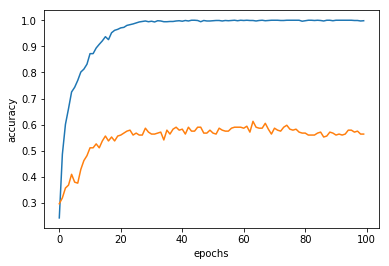

In [21]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()